# Baseline Model for Twitter Sentiment Analysis

This model will use Multinomial Naive Bayes with Vector Count (bag of words) to classify the tweets.

It will create bi-grams to attempt to add context to the words in the tweets.

It will add a list of common stop words to remove from the tweets when creating the bi-grams.

Like the model in [nb_model_01](nb_model_01) the min document frequency will be tested when creating the bi-grams

# Imports and Constants

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelBinarizer
import evaluation_functions

In [2]:
DATA_FILE_PATH = 'data/crowdflower-brands-and-product-emotions/data/'
TOKENIZED_DATA_FILE_NAME = 'tokenized_twitter_data.csv'
pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42

# Load Data

In [3]:
df = pd.read_csv(DATA_FILE_PATH + TOKENIZED_DATA_FILE_NAME)

In [4]:
df.head()

tweet_text  \
0             i have a g iphone after  hrs tweeting at #riseaustin it was dead  i need to upgrade plugin stations at #sxsw   
1   know about   awesome ipad/iphone app that you'll likely appreciate for its design also they're giving free ts at #sxsw   
2                                                         can not wait for #ipad  also they should sale them down at #sxsw   
3                                              i hope this year's festival isn't as crashy as this year's iphone app #sxsw   
4       great stuff on fri #sxsw: marissa mayer (google) tim o'reilly (tech books/conferences)  matt mullenweg (wordpress)   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  \
0                                   Negative emotion   
1                                   Positive emotion   
2                                   Positive emotion   
3                                   Negative emotion   
4                                   Positive emotion   

                                                                                                                                                                              tokens  
0         ['i', 'have', 'a', 'g', 'iphone', 'after', 'hrs', 'tweeting', 'at', '#riseaustin', 'it', 'was', 'dead', 'i', 'need', 'to', 'upgrade', 'plugin', 'stations', 'at', '#sxsw']  
1  ['know', 'about', 'awesome', 'ipad', 'iphone', 'app', 'that', "you'll", 'likely', 'appreciate', 'for', 'its', 'design', 'also', "they're", 'giving', 'free', 'ts', 'at', '#sxsw']  
2                                                                            ['can', 'not', 'wait', 'for', '#ipad', 'also', 'they', 'should', 'sale', 'them', 'down', 'at', '#sxsw']  
3                                                             ['i', 'hope', 'this', "year's", 'festival', "isn't", 'as', 'crashy', 'as', 'this', "year's", 'iphone', 'app', '#sxsw']  
4                        ['great', 'stuff', 'on', 'fri', '#sxsw', 'marissa', 'mayer', 'google', 'tim', "o'reilly", 'tech', 'books', 'conferences', 'matt', 'mullenweg', 'wordpress']

In [5]:
data = df[['tokens', 'is_there_an_emotion_directed_at_a_brand_or_product']]

In [6]:
data.head()

tokens  \
0         ['i', 'have', 'a', 'g', 'iphone', 'after', 'hrs', 'tweeting', 'at', '#riseaustin', 'it', 'was', 'dead', 'i', 'need', 'to', 'upgrade', 'plugin', 'stations', 'at', '#sxsw']   
1  ['know', 'about', 'awesome', 'ipad', 'iphone', 'app', 'that', "you'll", 'likely', 'appreciate', 'for', 'its', 'design', 'also', "they're", 'giving', 'free', 'ts', 'at', '#sxsw']   
2                                                                            ['can', 'not', 'wait', 'for', '#ipad', 'also', 'they', 'should', 'sale', 'them', 'down', 'at', '#sxsw']   
3                                                             ['i', 'hope', 'this', "year's", 'festival', "isn't", 'as', 'crashy', 'as', 'this', "year's", 'iphone', 'app', '#sxsw']   
4                        ['great', 'stuff', 'on', 'fri', '#sxsw', 'marissa', 'mayer', 'google', 'tim', "o'reilly", 'tech', 'books', 'conferences', 'matt', 'mullenweg', 'wordpress']   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion

# Split Data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data['tokens'], 
                                                    data['is_there_an_emotion_directed_at_a_brand_or_product'],
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = data['is_there_an_emotion_directed_at_a_brand_or_product'])

In [8]:
X_train.shape

(6855,)

In [9]:
X_test.shape

(1714,)

# Encode Labels

In [10]:
le = LabelEncoder()

In [11]:
y_train_enc = le.fit_transform(y_train)

In [12]:
y_test_enc = le.transform(y_test)

# Evaluate Adjustments to Minimum Document Frequency

In [17]:
def train_and_eval_model(min_df, ngram_range):
    """
    Train and Evaluate and Bag of Words Representation with a Naive Bayes
    classifier with a specified minimum document frequency.
    """
    
    stop_words = ['the', 'to', 'at', 'rt', 'for', 'a', 'in', 'is', 'of', 
                  'and', 'on', 'i', 'you', 'an', 'with', 'it', 'this']
    
    pipeline = Pipeline([
    ('bow',CountVectorizer(min_df=min_df, 
                           ngram_range=ngram_range, 
                           max_features=10000, 
                           stop_words=stop_words)),  # bag of words
    ('classifier', MultinomialNB()),  # train on bag of words vectors w/ Naive Bayes classifier
    ])
    
    pipeline.fit(X_train,y_train_enc)
    
    print(f'MINIMUM DOCUMENT FREQUENCY = {min_df}')
    print('')
    
    evaluation_functions.confustion_matrix_and_classification_report(pipeline, 
                                                                 X_train, 
                                                                 y_train_enc, 
                                                                 le.classes_, 
                                                                 'Training')
    
    evaluation_functions.confustion_matrix_and_classification_report(pipeline, 
                                                                 X_test, 
                                                                 y_test_enc, 
                                                                 le.classes_,
                                                                 'Test')
    
    lb = LabelBinarizer()
    lb.fit(y_test_enc)
    y_test_multi = lb.transform(y_test_enc)
    y_hat_test_multi = pipeline.predict_proba(X_test)
    
    evaluation_functions.pr_curves(y_test_multi, y_hat_test_multi, le.classes_)
    
    train_accuracy = accuracy_score(y_train_enc, pipeline.predict(X_train))
    
    test_accuracy = accuracy_score(y_test_enc, pipeline.predict(X_test))
        
    f1_scores = f1_score(y_test_enc, pipeline.predict(X_test), average=None)
    
    test_results = np.append(np.array([min_df, train_accuracy, test_accuracy]),
                             f1_scores)
   
    return test_results
    

MINIMUM DOCUMENT FREQUENCY = 1

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.76      0.62      0.69       436
No emotion toward brand or product       0.86      0.87      0.86      4124
                  Positive emotion       0.77      0.78      0.78      2295

                          accuracy                           0.82      6855
                         macro avg       0.80      0.76      0.77      6855
                      weighted avg       0.82      0.82      0.82      6855



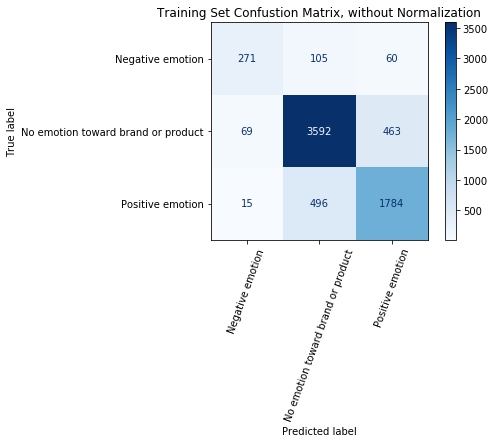

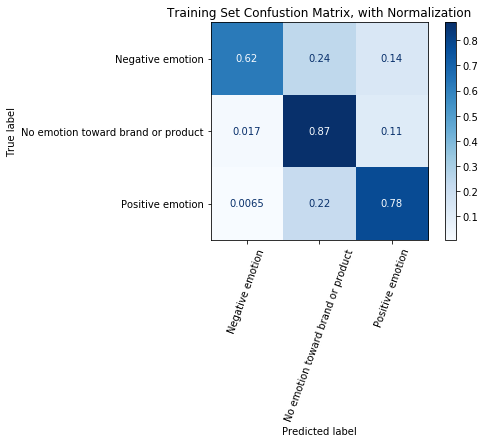

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.42      0.17      0.24       109
No emotion toward brand or product       0.71      0.77      0.74      1031
                  Positive emotion       0.57      0.55      0.56       574

                          accuracy                           0.66      1714
                         macro avg       0.57      0.49      0.51      1714
                      weighted avg       0.64      0.66      0.65      1714



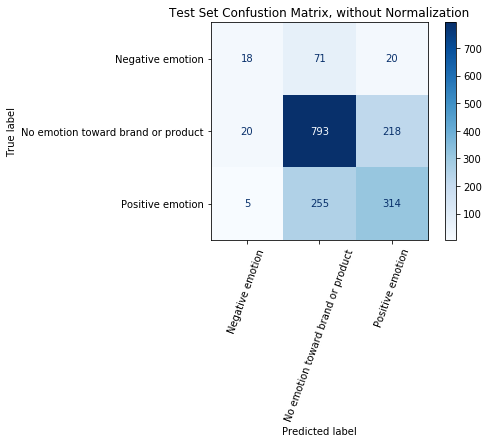

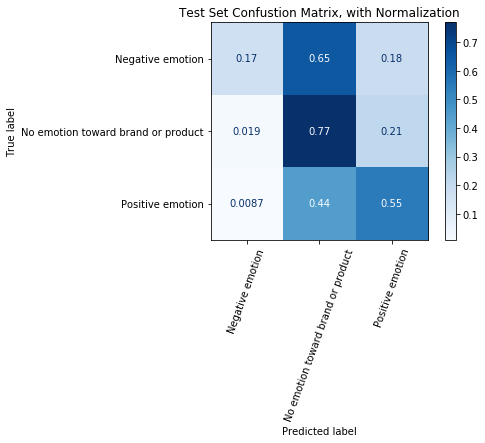

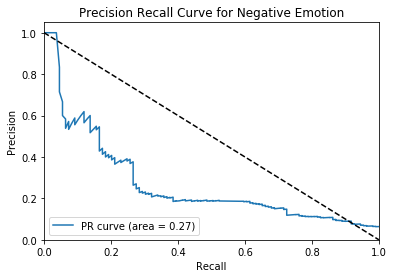

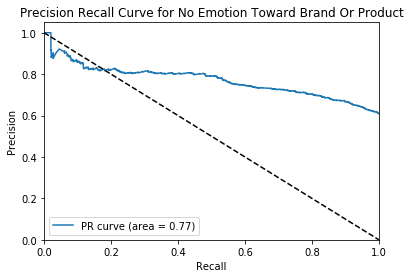

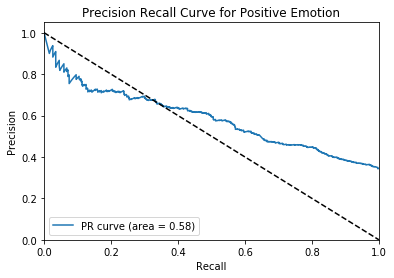

MINIMUM DOCUMENT FREQUENCY = 2

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.77      0.63      0.69       436
No emotion toward brand or product       0.85      0.87      0.86      4124
                  Positive emotion       0.77      0.77      0.77      2295

                          accuracy                           0.82      6855
                         macro avg       0.80      0.76      0.77      6855
                      weighted avg       0.82      0.82      0.82      6855



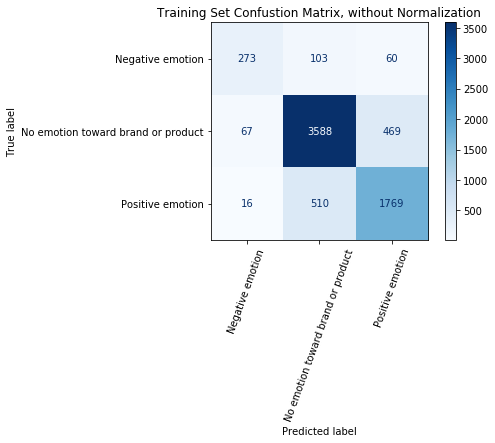

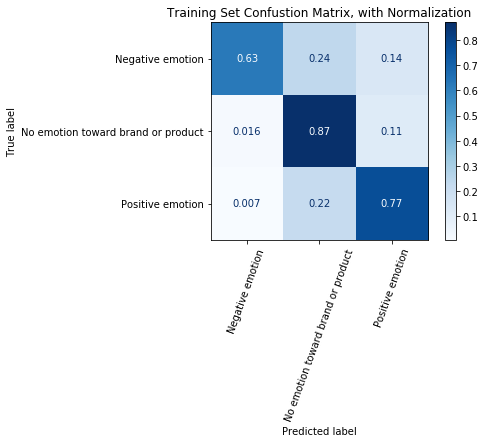

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.44      0.19      0.27       109
No emotion toward brand or product       0.71      0.77      0.74      1031
                  Positive emotion       0.56      0.54      0.55       574

                          accuracy                           0.65      1714
                         macro avg       0.57      0.50      0.52      1714
                      weighted avg       0.64      0.65      0.64      1714



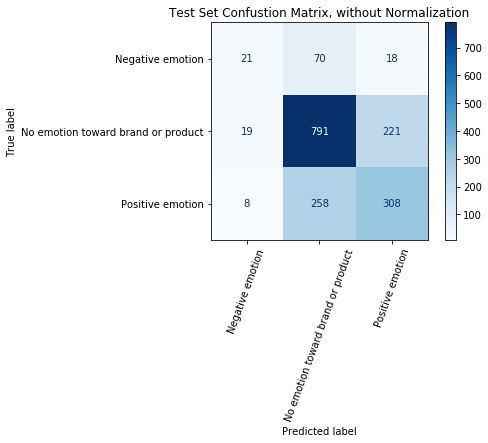

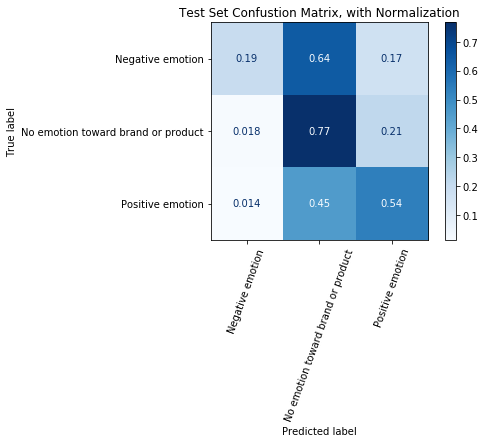

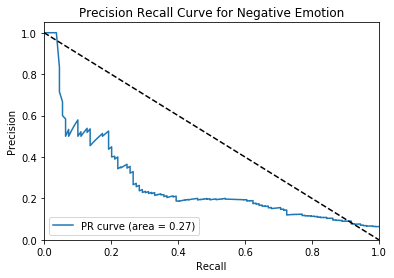

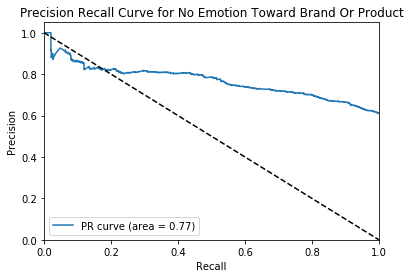

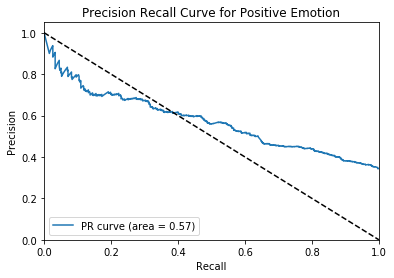

MINIMUM DOCUMENT FREQUENCY = 3

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.62      0.54      0.58       436
No emotion toward brand or product       0.82      0.83      0.83      4124
                  Positive emotion       0.72      0.72      0.72      2295

                          accuracy                           0.78      6855
                         macro avg       0.72      0.70      0.71      6855
                      weighted avg       0.78      0.78      0.78      6855



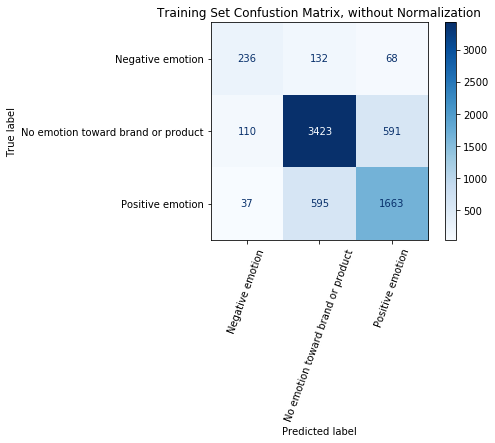

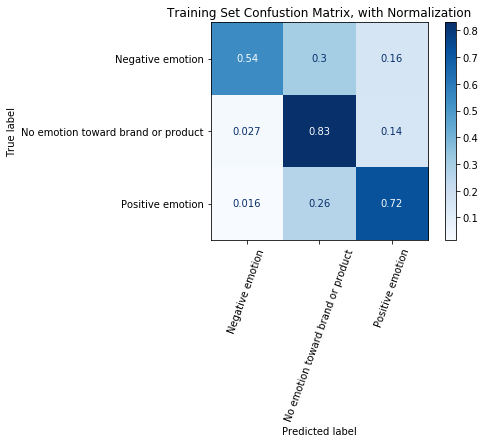

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.36      0.22      0.27       109
No emotion toward brand or product       0.71      0.74      0.73      1031
                  Positive emotion       0.54      0.53      0.54       574

                          accuracy                           0.64      1714
                         macro avg       0.54      0.50      0.51      1714
                      weighted avg       0.63      0.64      0.63      1714



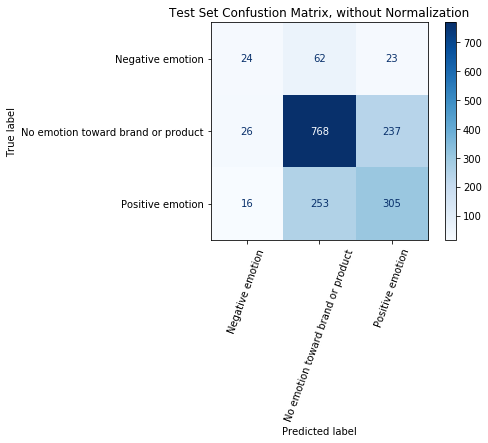

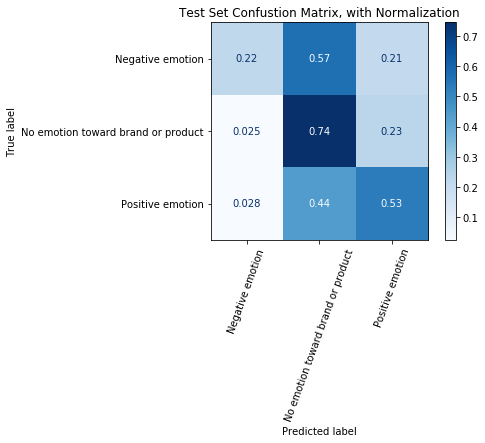

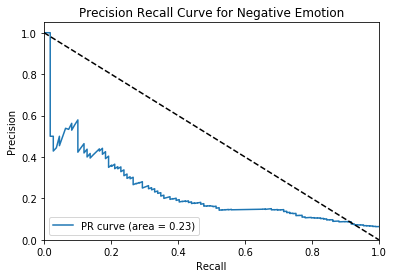

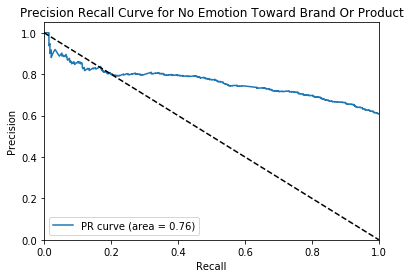

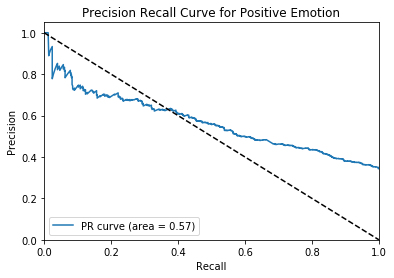

MINIMUM DOCUMENT FREQUENCY = 4

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.55      0.46      0.50       436
No emotion toward brand or product       0.79      0.81      0.80      4124
                  Positive emotion       0.67      0.66      0.67      2295

                          accuracy                           0.74      6855
                         macro avg       0.67      0.64      0.66      6855
                      weighted avg       0.73      0.74      0.74      6855



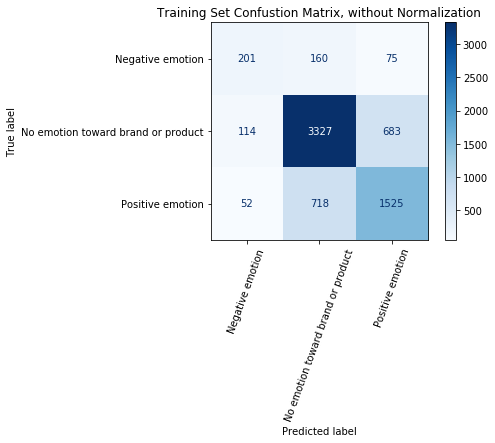

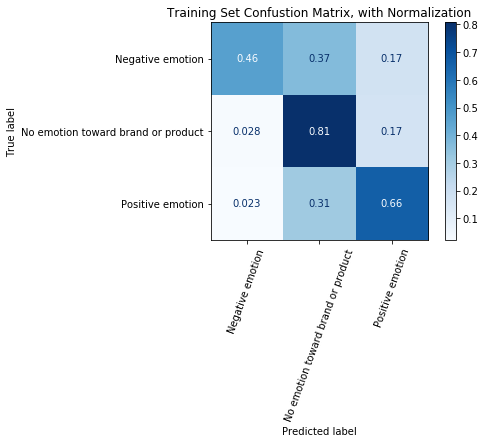

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.29      0.19      0.23       109
No emotion toward brand or product       0.70      0.73      0.71      1031
                  Positive emotion       0.52      0.51      0.52       574

                          accuracy                           0.62      1714
                         macro avg       0.50      0.48      0.49      1714
                      weighted avg       0.61      0.62      0.62      1714



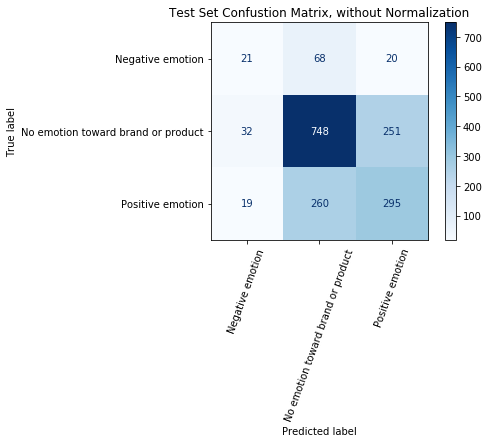

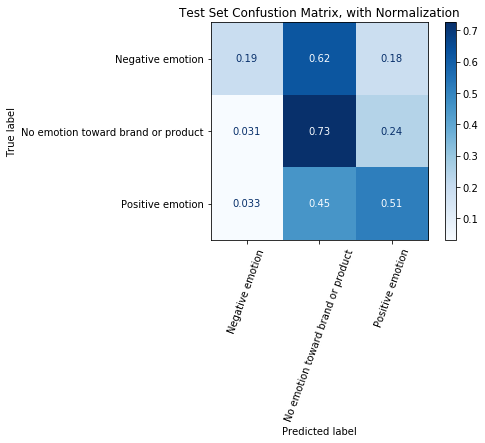

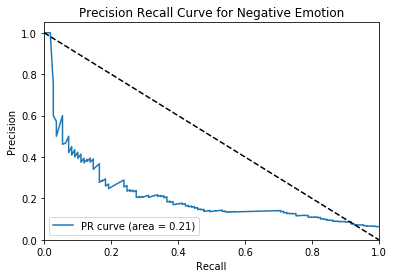

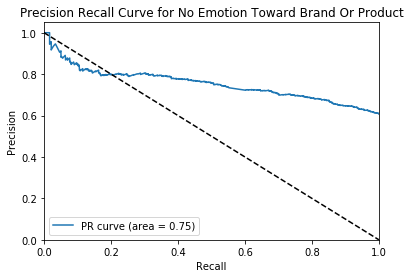

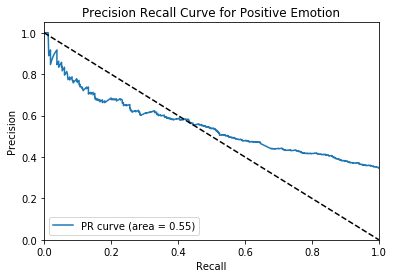

MINIMUM DOCUMENT FREQUENCY = 5

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.53      0.41      0.46       436
No emotion toward brand or product       0.77      0.80      0.79      4124
                  Positive emotion       0.64      0.63      0.64      2295

                          accuracy                           0.72      6855
                         macro avg       0.65      0.61      0.63      6855
                      weighted avg       0.71      0.72      0.71      6855



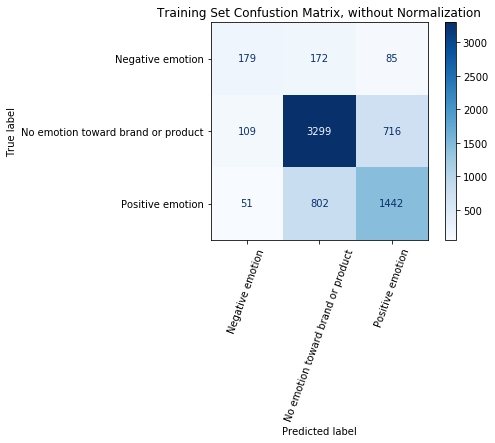

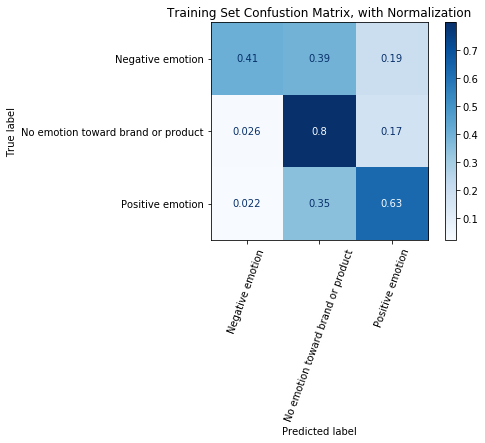

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.31      0.17      0.22       109
No emotion toward brand or product       0.68      0.73      0.71      1031
                  Positive emotion       0.51      0.49      0.50       574

                          accuracy                           0.61      1714
                         macro avg       0.50      0.46      0.48      1714
                      weighted avg       0.60      0.61      0.61      1714



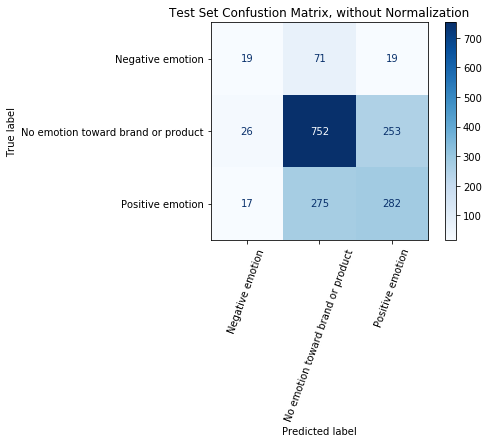

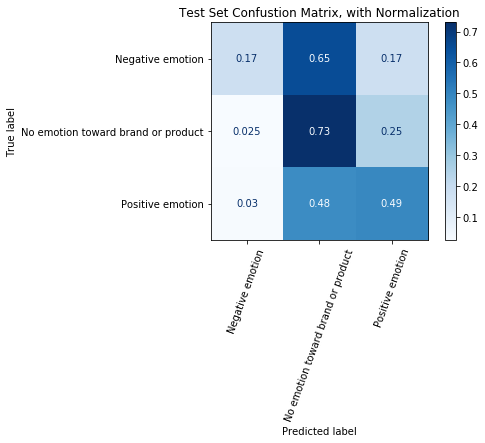

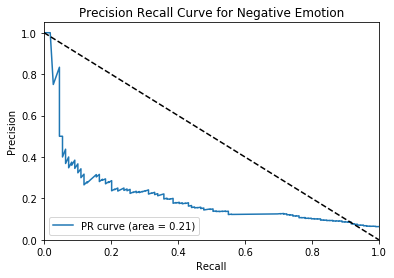

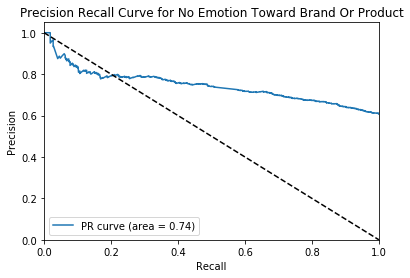

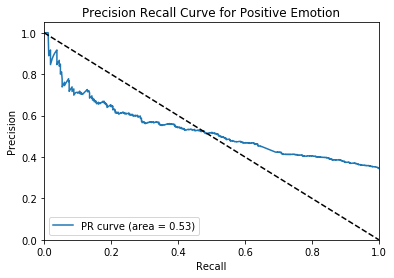

MINIMUM DOCUMENT FREQUENCY = 6

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.48      0.36      0.41       436
No emotion toward brand or product       0.75      0.80      0.78      4124
                  Positive emotion       0.63      0.59      0.61      2295

                          accuracy                           0.70      6855
                         macro avg       0.62      0.58      0.60      6855
                      weighted avg       0.69      0.70      0.70      6855



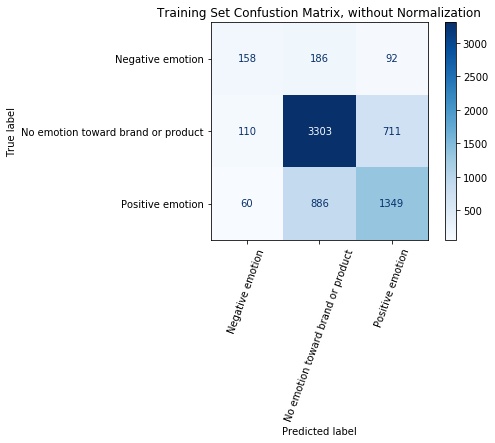

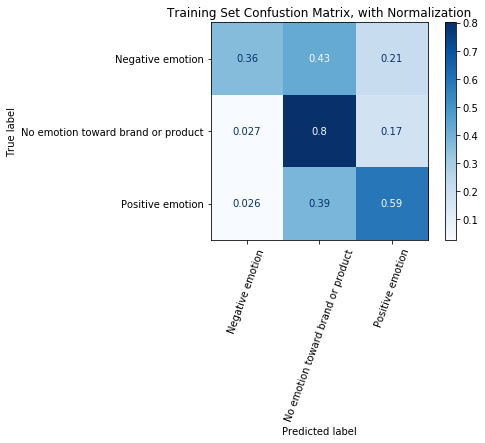

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.27      0.15      0.19       109
No emotion toward brand or product       0.67      0.73      0.70      1031
                  Positive emotion       0.50      0.46      0.48       574

                          accuracy                           0.61      1714
                         macro avg       0.48      0.45      0.46      1714
                      weighted avg       0.59      0.61      0.59      1714



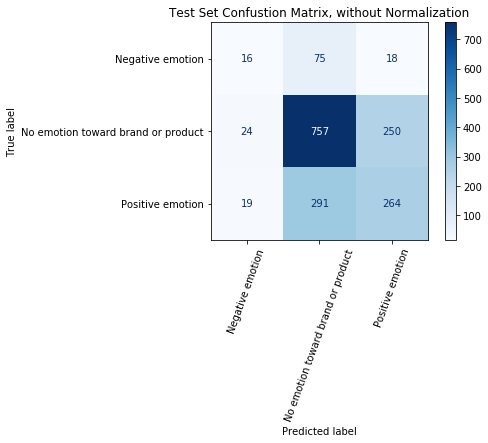

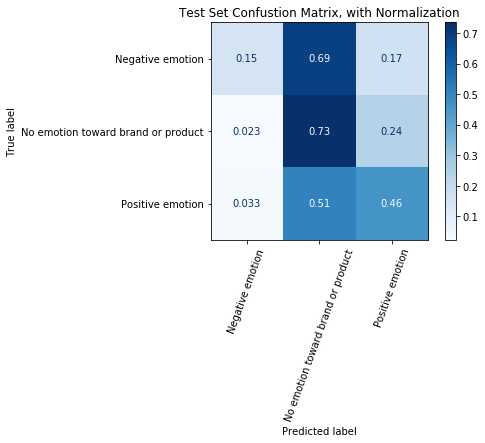

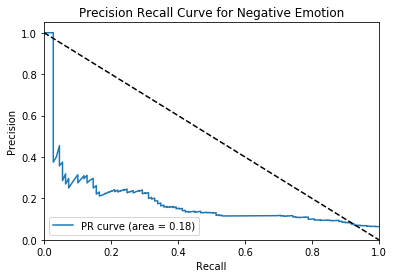

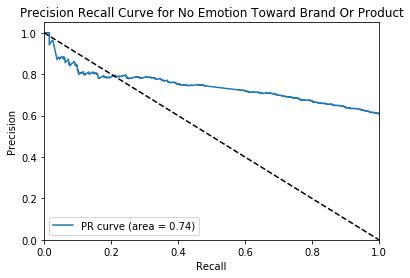

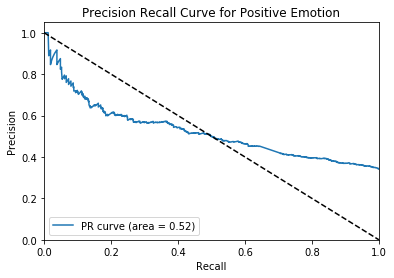

MINIMUM DOCUMENT FREQUENCY = 7

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.45      0.33      0.38       436
No emotion toward brand or product       0.74      0.80      0.77      4124
                  Positive emotion       0.61      0.55      0.58      2295

                          accuracy                           0.69      6855
                         macro avg       0.60      0.56      0.58      6855
                      weighted avg       0.68      0.69      0.68      6855



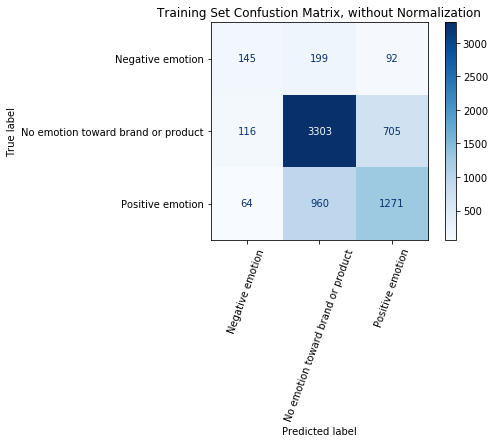

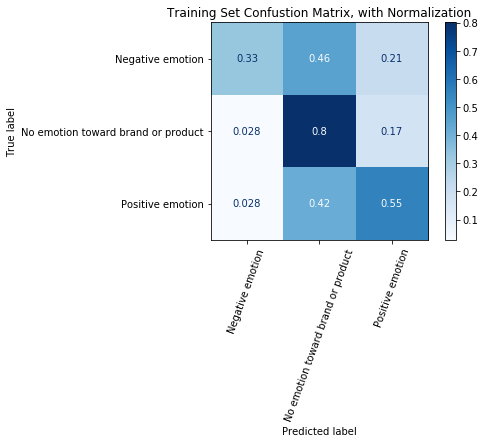

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.28      0.15      0.19       109
No emotion toward brand or product       0.67      0.74      0.70      1031
                  Positive emotion       0.50      0.44      0.47       574

                          accuracy                           0.60      1714
                         macro avg       0.48      0.44      0.45      1714
                      weighted avg       0.59      0.60      0.59      1714



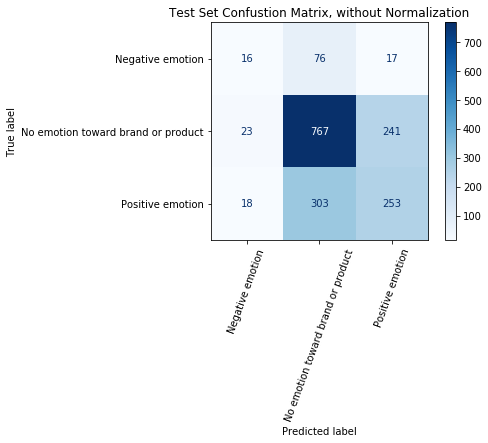

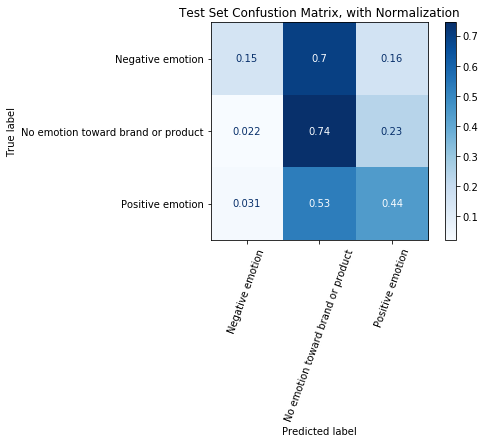

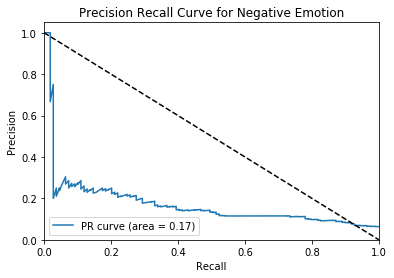

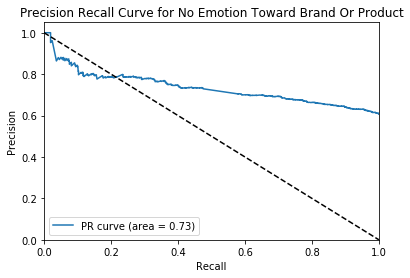

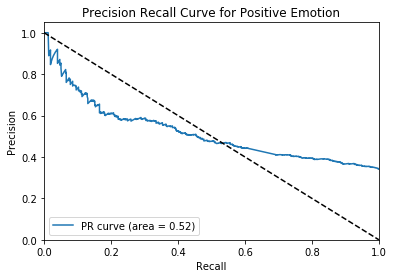

MINIMUM DOCUMENT FREQUENCY = 8

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.44      0.29      0.35       436
No emotion toward brand or product       0.73      0.79      0.76      4124
                  Positive emotion       0.59      0.54      0.56      2295

                          accuracy                           0.67      6855
                         macro avg       0.59      0.54      0.56      6855
                      weighted avg       0.66      0.67      0.67      6855



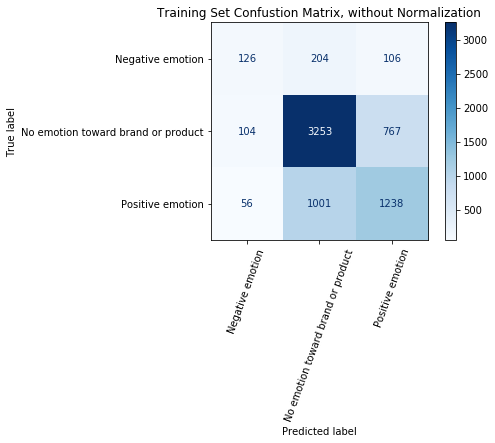

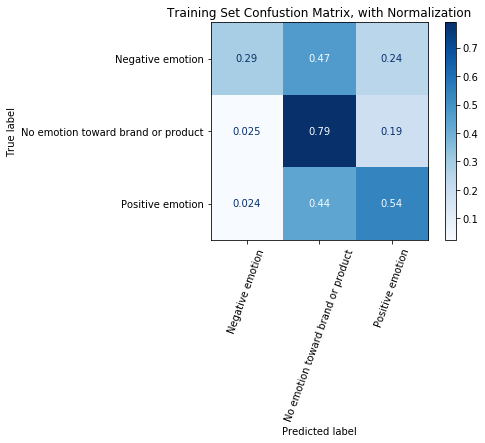

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.26      0.13      0.17       109
No emotion toward brand or product       0.67      0.73      0.70      1031
                  Positive emotion       0.49      0.45      0.47       574

                          accuracy                           0.60      1714
                         macro avg       0.47      0.44      0.45      1714
                      weighted avg       0.58      0.60      0.59      1714



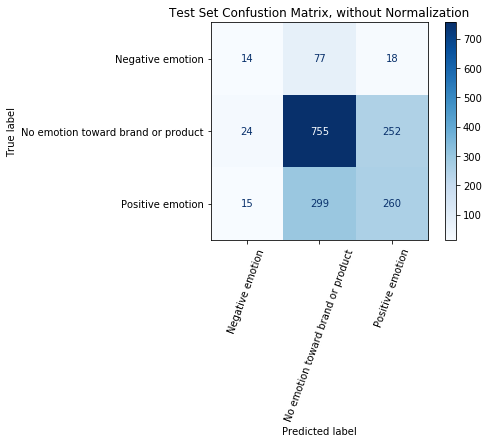

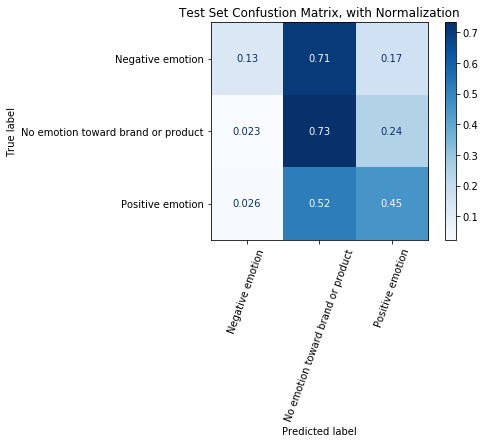

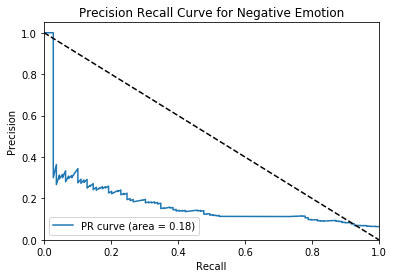

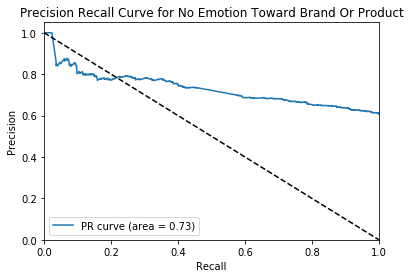

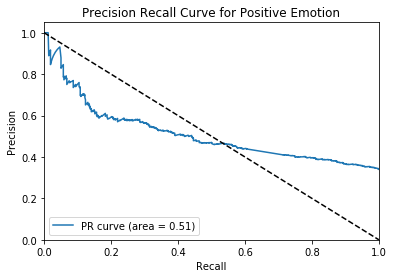

MINIMUM DOCUMENT FREQUENCY = 9

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.43      0.26      0.33       436
No emotion toward brand or product       0.72      0.79      0.76      4124
                  Positive emotion       0.58      0.52      0.55      2295

                          accuracy                           0.67      6855
                         macro avg       0.58      0.53      0.54      6855
                      weighted avg       0.66      0.67      0.66      6855



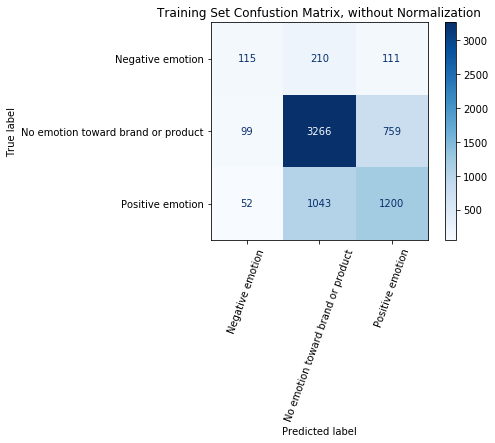

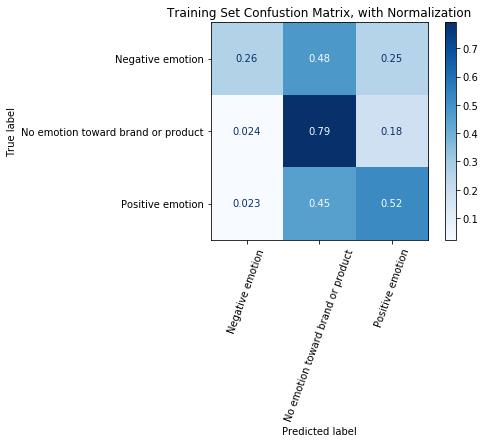

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.28      0.14      0.19       109
No emotion toward brand or product       0.67      0.74      0.70      1031
                  Positive emotion       0.50      0.45      0.47       574

                          accuracy                           0.60      1714
                         macro avg       0.48      0.44      0.45      1714
                      weighted avg       0.59      0.60      0.59      1714



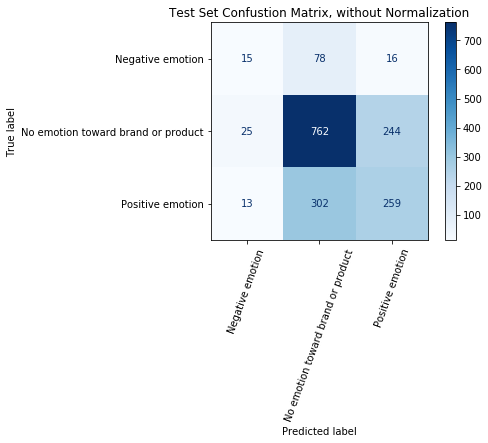

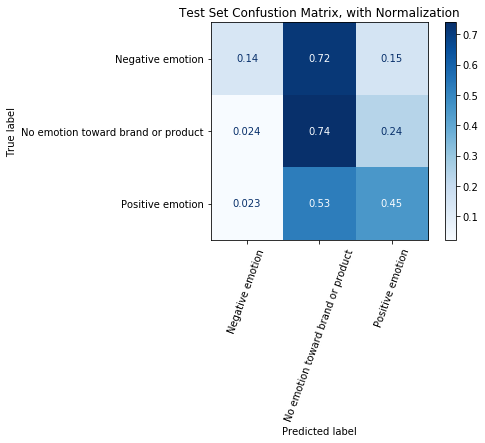

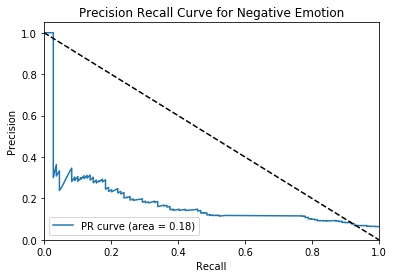

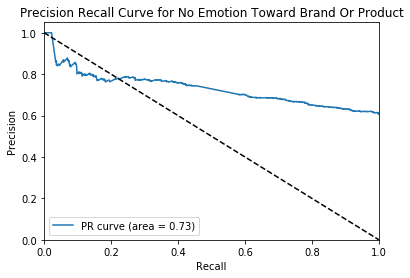

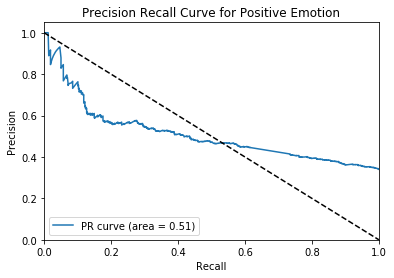

MINIMUM DOCUMENT FREQUENCY = 10

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.42      0.23      0.30       436
No emotion toward brand or product       0.71      0.79      0.75      4124
                  Positive emotion       0.57      0.51      0.54      2295

                          accuracy                           0.66      6855
                         macro avg       0.57      0.51      0.53      6855
                      weighted avg       0.65      0.66      0.65      6855



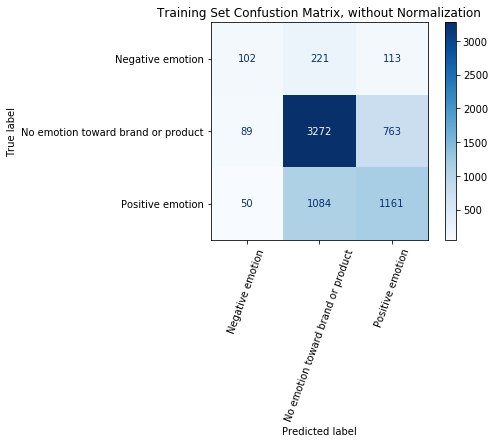

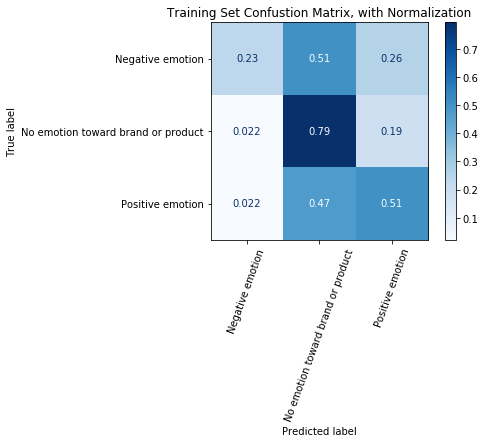

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.38      0.17      0.23       109
No emotion toward brand or product       0.66      0.74      0.70      1031
                  Positive emotion       0.50      0.44      0.47       574

                          accuracy                           0.61      1714
                         macro avg       0.52      0.45      0.47      1714
                      weighted avg       0.59      0.61      0.59      1714



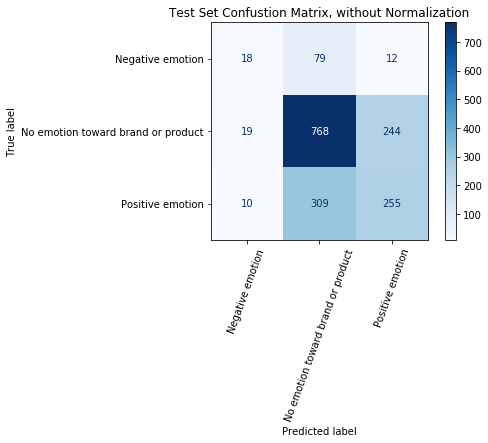

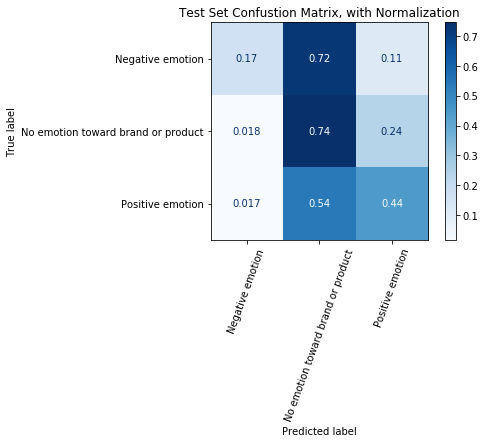

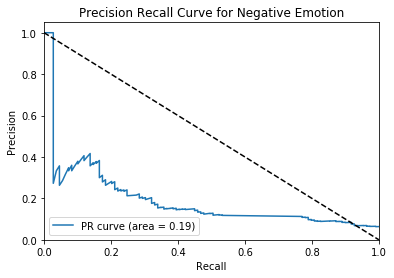

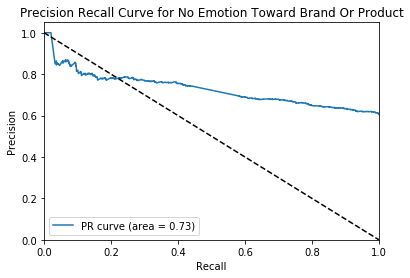

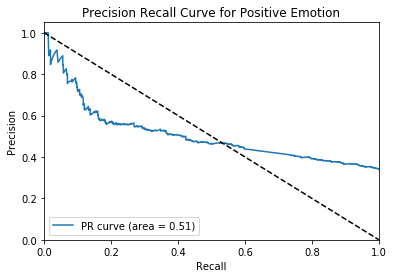

MINIMUM DOCUMENT FREQUENCY = 11

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.38      0.19      0.26       436
No emotion toward brand or product       0.71      0.79      0.75      4124
                  Positive emotion       0.56      0.49      0.53      2295

                          accuracy                           0.65      6855
                         macro avg       0.55      0.49      0.51      6855
                      weighted avg       0.64      0.65      0.64      6855



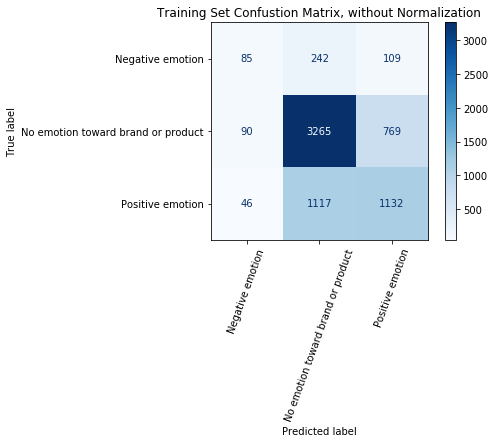

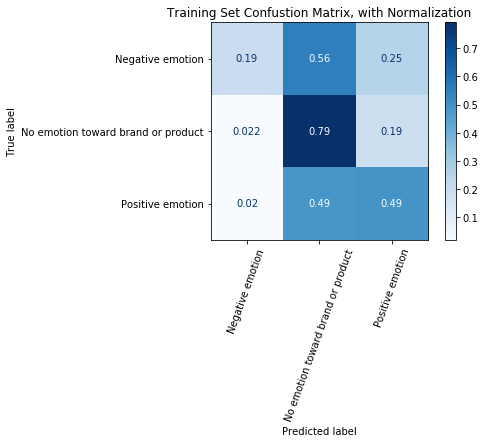

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.34      0.13      0.19       109
No emotion toward brand or product       0.66      0.75      0.70      1031
                  Positive emotion       0.49      0.43      0.46       574

                          accuracy                           0.60      1714
                         macro avg       0.50      0.44      0.45      1714
                      weighted avg       0.58      0.60      0.59      1714



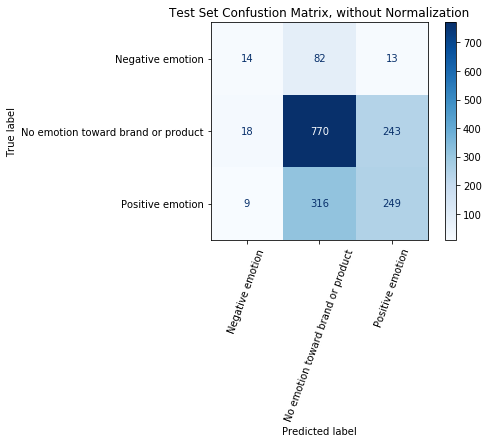

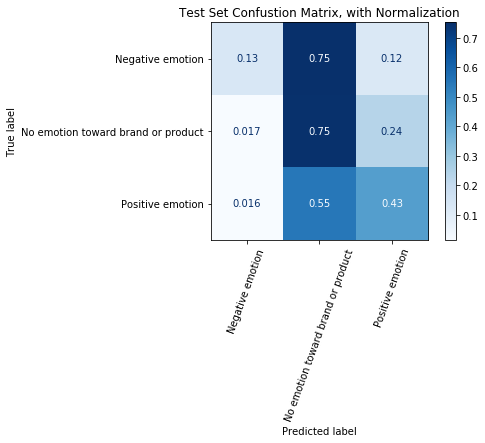

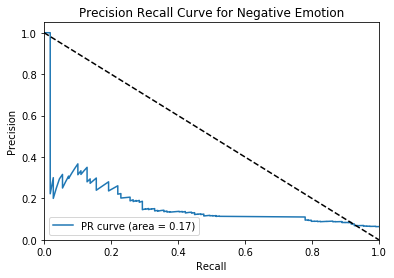

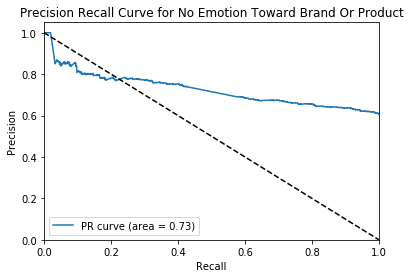

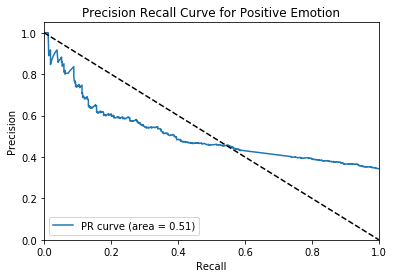

MINIMUM DOCUMENT FREQUENCY = 12

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.39      0.17      0.24       436
No emotion toward brand or product       0.70      0.80      0.75      4124
                  Positive emotion       0.56      0.48      0.51      2295

                          accuracy                           0.65      6855
                         macro avg       0.55      0.48      0.50      6855
                      weighted avg       0.63      0.65      0.64      6855



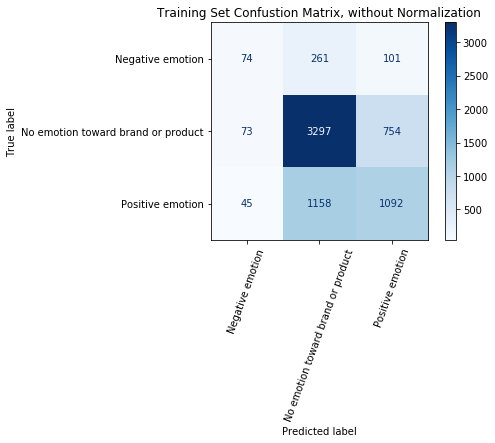

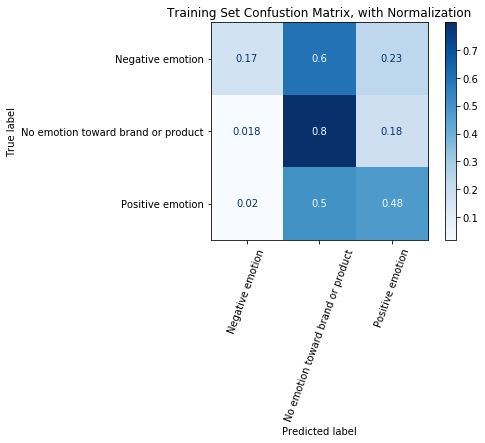

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.35      0.10      0.16       109
No emotion toward brand or product       0.66      0.76      0.71      1031
                  Positive emotion       0.49      0.42      0.45       574

                          accuracy                           0.60      1714
                         macro avg       0.50      0.43      0.44      1714
                      weighted avg       0.58      0.60      0.59      1714



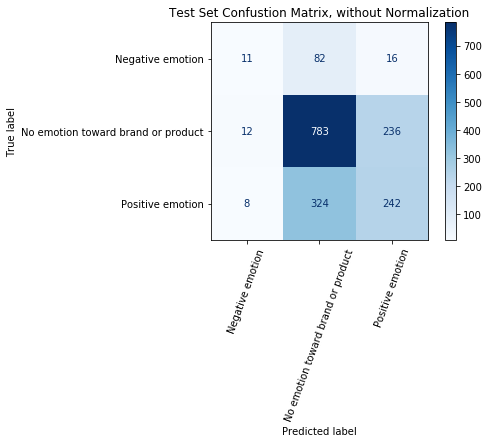

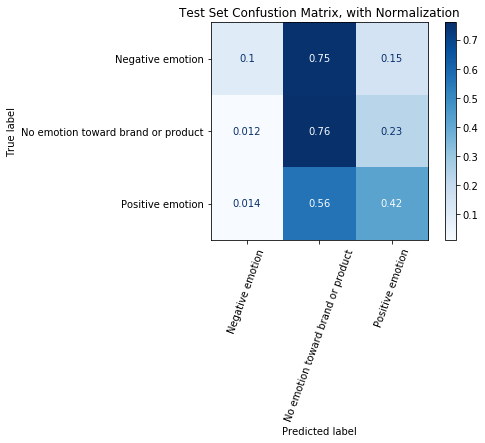

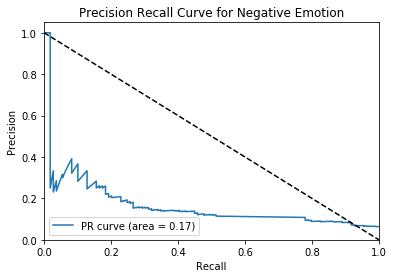

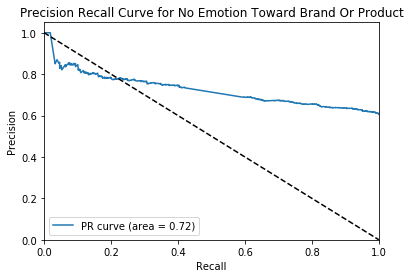

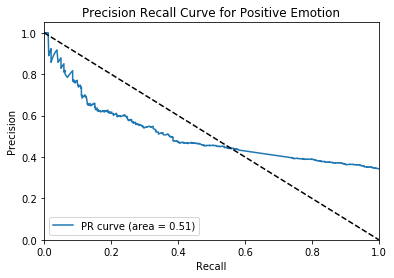

MINIMUM DOCUMENT FREQUENCY = 13

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.31      0.13      0.18       436
No emotion toward brand or product       0.69      0.80      0.74      4124
                  Positive emotion       0.56      0.45      0.50      2295

                          accuracy                           0.64      6855
                         macro avg       0.52      0.46      0.47      6855
                      weighted avg       0.62      0.64      0.62      6855



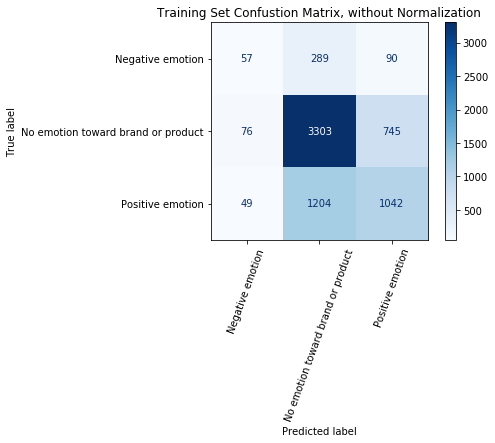

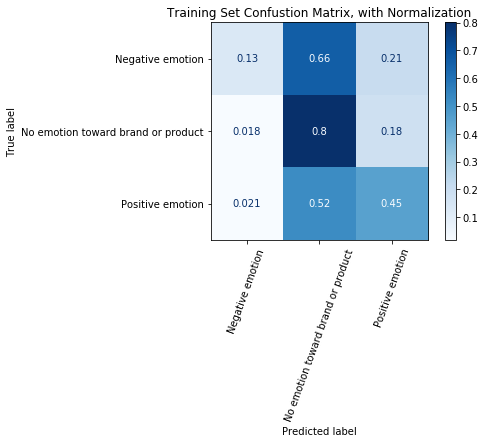

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.37      0.10      0.16       109
No emotion toward brand or product       0.66      0.77      0.71      1031
                  Positive emotion       0.50      0.41      0.45       574

                          accuracy                           0.61      1714
                         macro avg       0.51      0.43      0.44      1714
                      weighted avg       0.59      0.61      0.59      1714



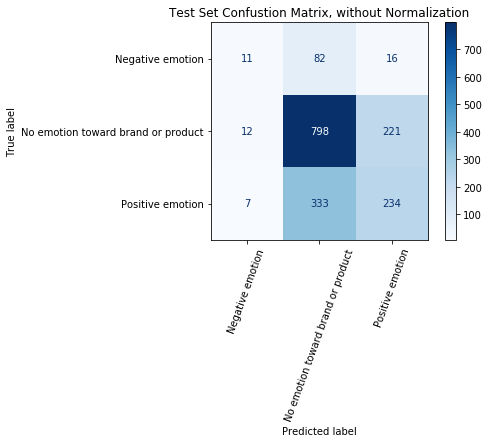

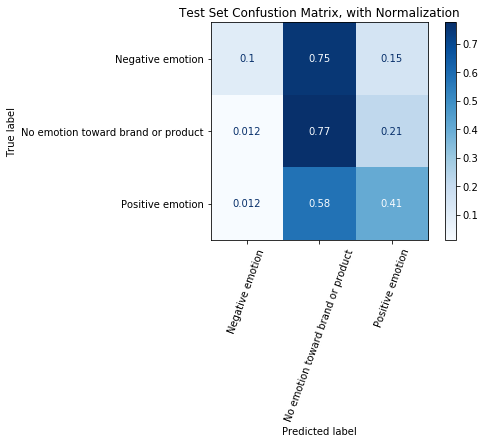

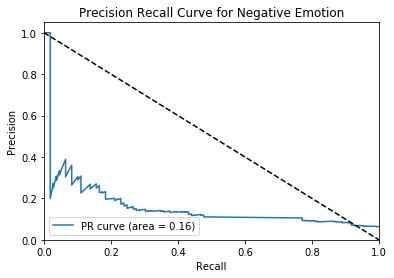

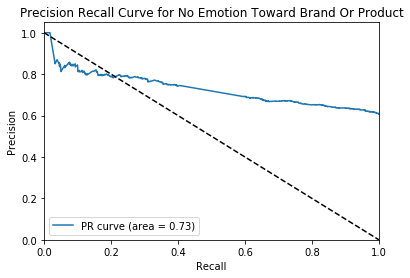

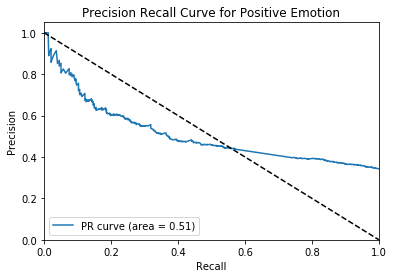

MINIMUM DOCUMENT FREQUENCY = 14

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.30      0.12      0.17       436
No emotion toward brand or product       0.69      0.81      0.74      4124
                  Positive emotion       0.55      0.44      0.49      2295

                          accuracy                           0.64      6855
                         macro avg       0.51      0.46      0.47      6855
                      weighted avg       0.62      0.64      0.62      6855



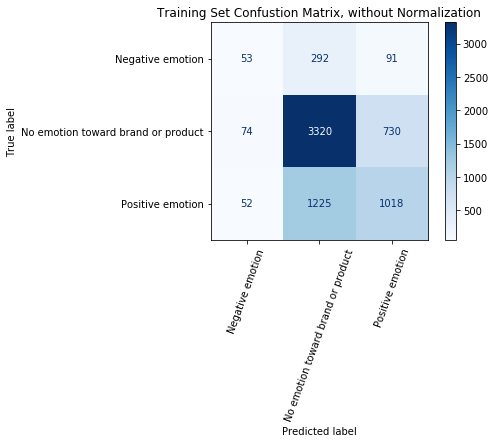

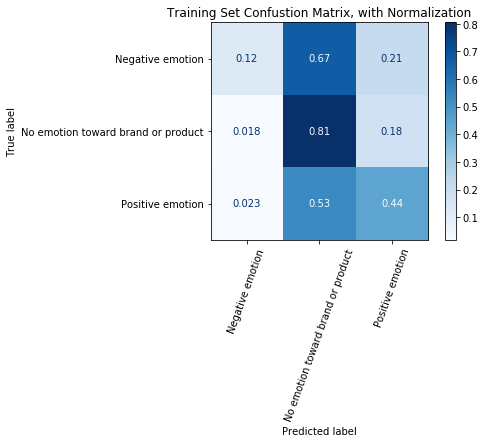

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.38      0.10      0.16       109
No emotion toward brand or product       0.66      0.78      0.72      1031
                  Positive emotion       0.51      0.41      0.45       574

                          accuracy                           0.61      1714
                         macro avg       0.52      0.43      0.44      1714
                      weighted avg       0.59      0.61      0.59      1714



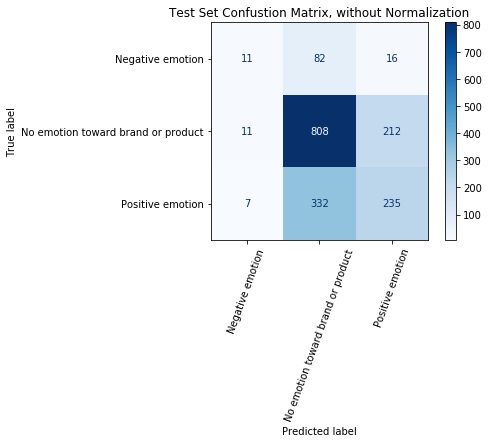

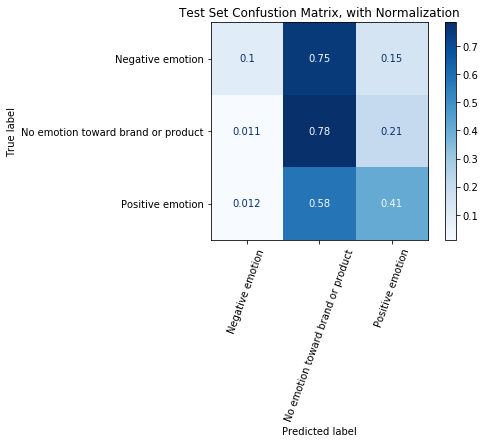

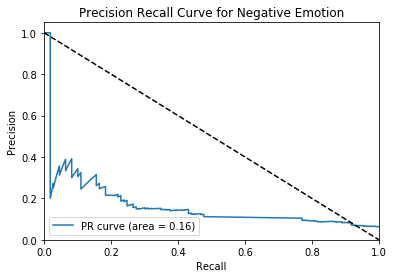

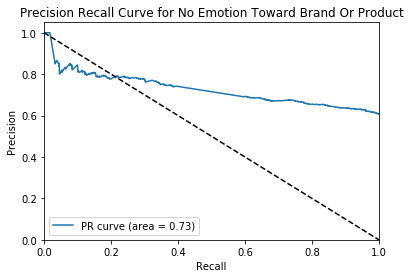

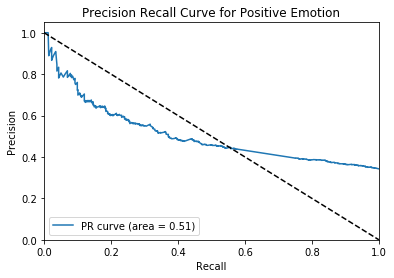

MINIMUM DOCUMENT FREQUENCY = 15

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.30      0.12      0.17       436
No emotion toward brand or product       0.68      0.81      0.74      4124
                  Positive emotion       0.55      0.43      0.48      2295

                          accuracy                           0.64      6855
                         macro avg       0.51      0.45      0.46      6855
                      weighted avg       0.61      0.64      0.62      6855



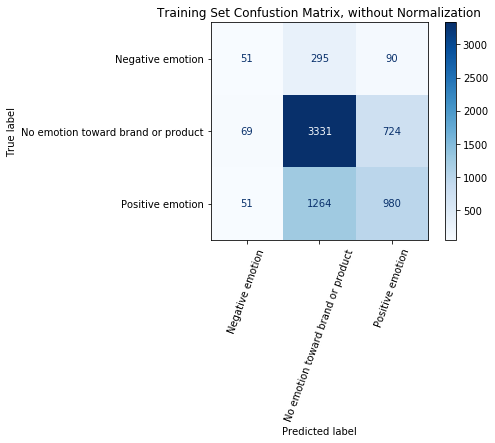

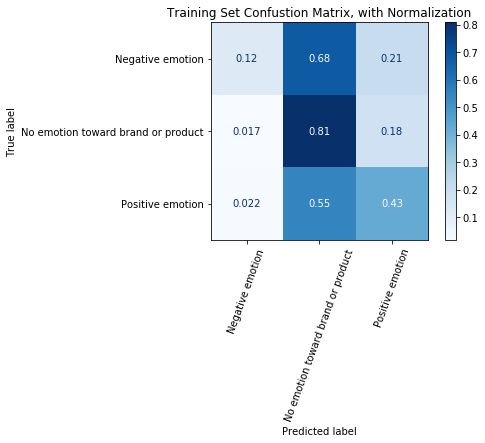

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.38      0.10      0.16       109
No emotion toward brand or product       0.66      0.78      0.72      1031
                  Positive emotion       0.51      0.40      0.45       574

                          accuracy                           0.61      1714
                         macro avg       0.51      0.43      0.44      1714
                      weighted avg       0.59      0.61      0.59      1714



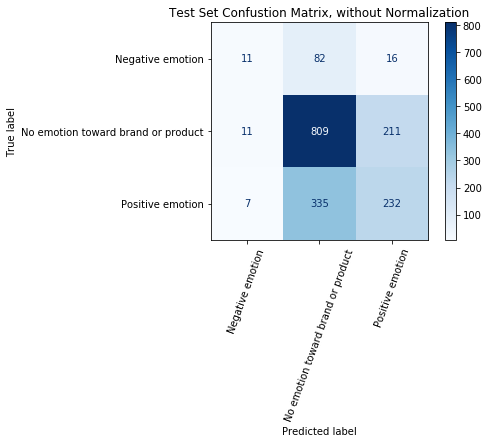

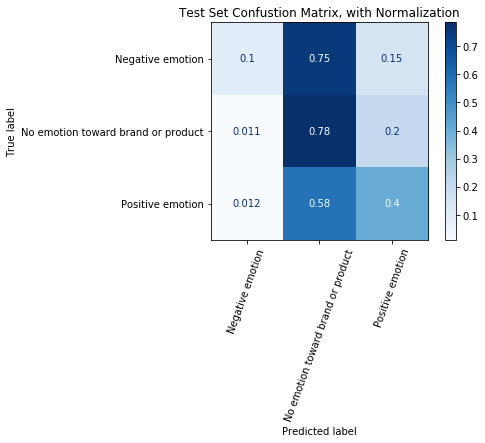

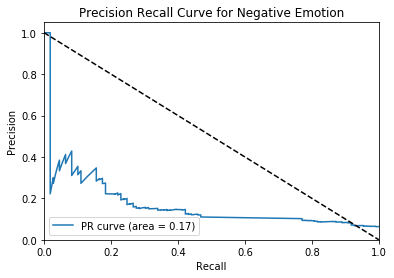

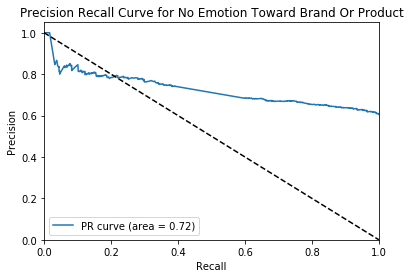

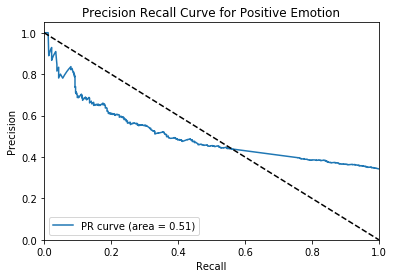

MINIMUM DOCUMENT FREQUENCY = 16

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.30      0.11      0.16       436
No emotion toward brand or product       0.68      0.81      0.74      4124
                  Positive emotion       0.54      0.41      0.47      2295

                          accuracy                           0.63      6855
                         macro avg       0.51      0.44      0.46      6855
                      weighted avg       0.61      0.63      0.61      6855



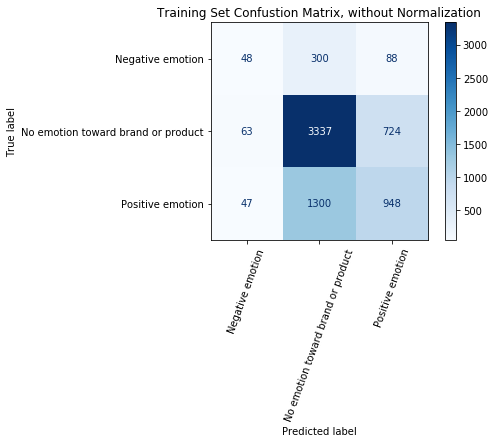

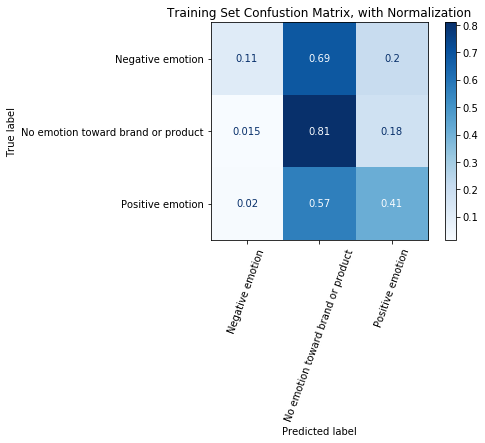

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.33      0.08      0.13       109
No emotion toward brand or product       0.66      0.78      0.71      1031
                  Positive emotion       0.50      0.41      0.45       574

                          accuracy                           0.61      1714
                         macro avg       0.50      0.42      0.43      1714
                      weighted avg       0.58      0.61      0.59      1714



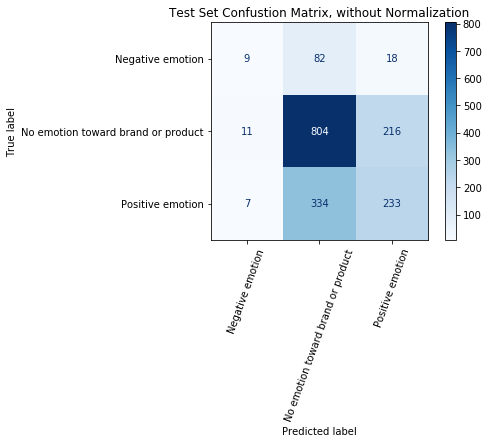

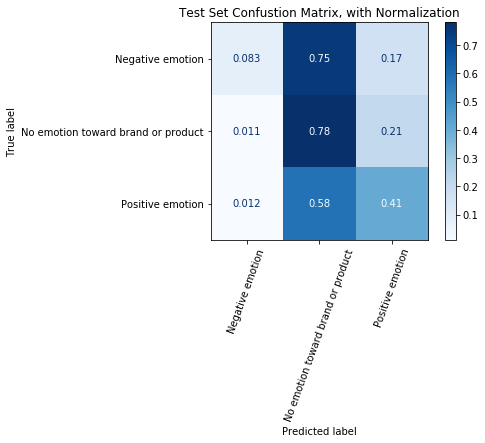

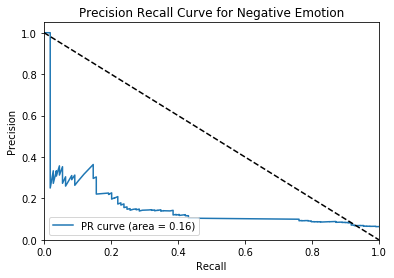

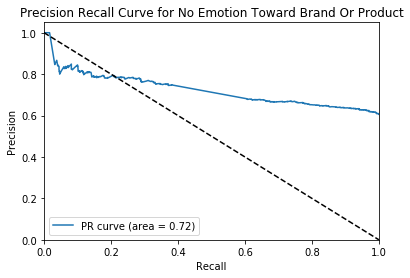

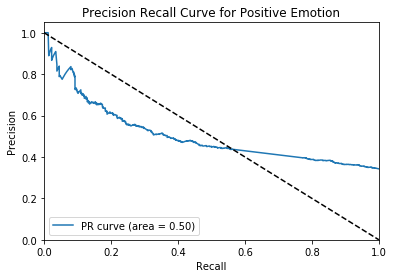

MINIMUM DOCUMENT FREQUENCY = 17

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.31      0.10      0.15       436
No emotion toward brand or product       0.67      0.81      0.73      4124
                  Positive emotion       0.53      0.40      0.46      2295

                          accuracy                           0.63      6855
                         macro avg       0.50      0.44      0.45      6855
                      weighted avg       0.60      0.63      0.61      6855



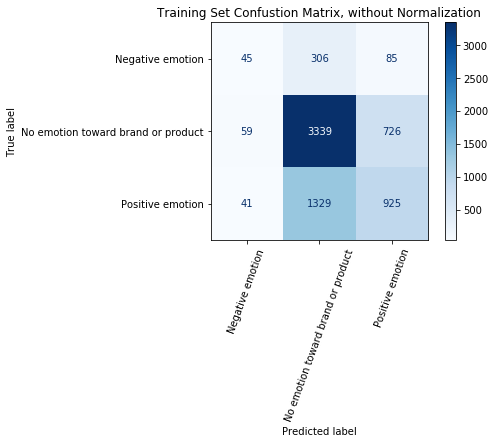

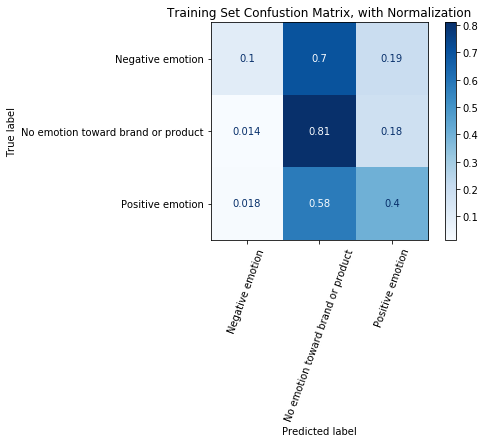

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.28      0.06      0.10       109
No emotion toward brand or product       0.65      0.78      0.71      1031
                  Positive emotion       0.49      0.40      0.44       574

                          accuracy                           0.60      1714
                         macro avg       0.47      0.41      0.42      1714
                      weighted avg       0.57      0.60      0.58      1714



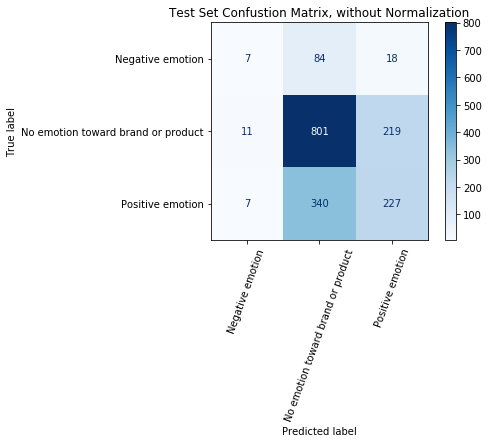

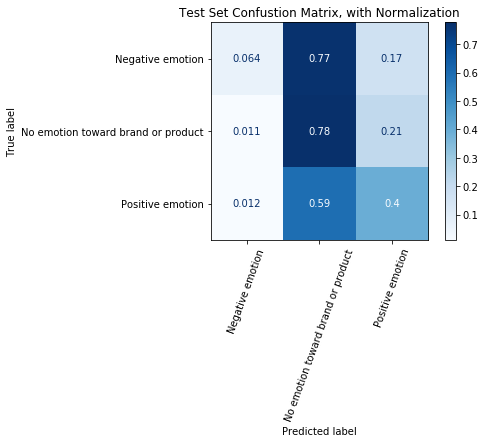

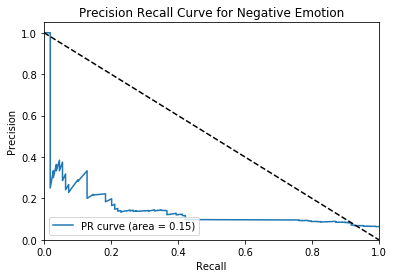

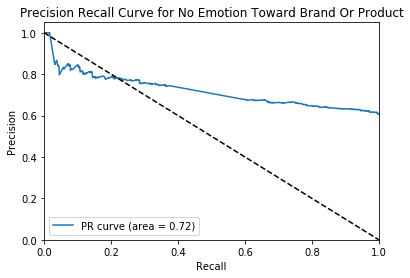

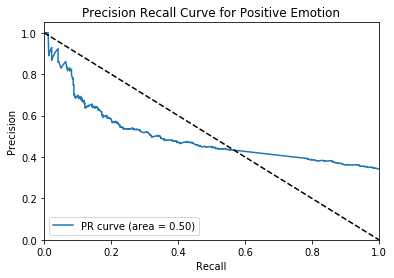

MINIMUM DOCUMENT FREQUENCY = 18

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.32      0.10      0.15       436
No emotion toward brand or product       0.67      0.82      0.74      4124
                  Positive emotion       0.53      0.40      0.45      2295

                          accuracy                           0.63      6855
                         macro avg       0.51      0.44      0.45      6855
                      weighted avg       0.60      0.63      0.60      6855



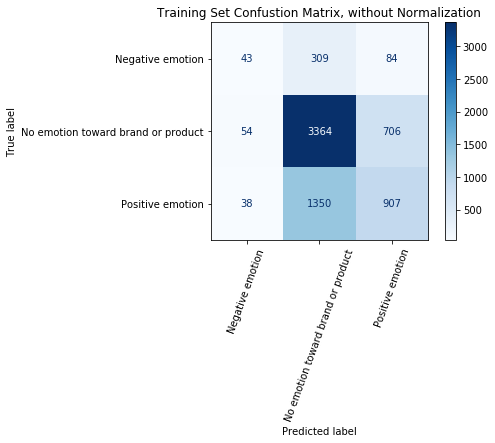

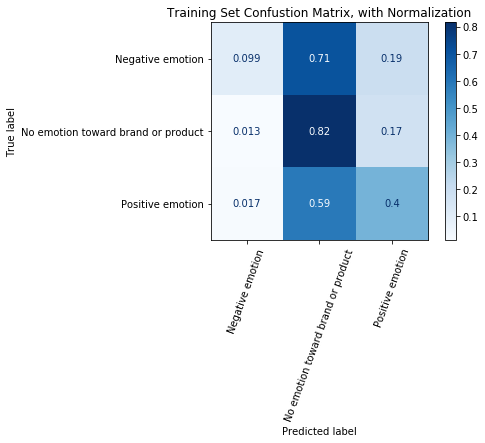

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.25      0.06      0.09       109
No emotion toward brand or product       0.65      0.78      0.71      1031
                  Positive emotion       0.49      0.40      0.44       574

                          accuracy                           0.60      1714
                         macro avg       0.47      0.41      0.41      1714
                      weighted avg       0.57      0.60      0.58      1714



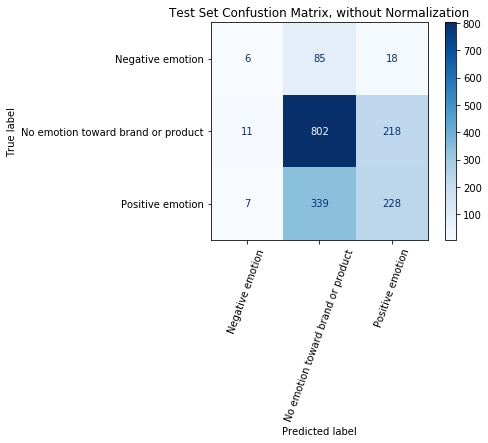

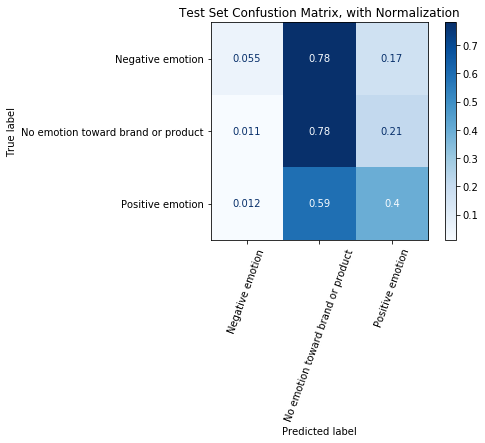

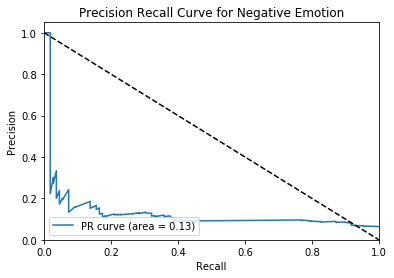

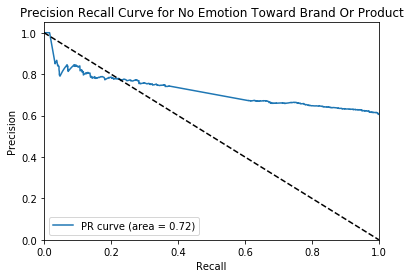

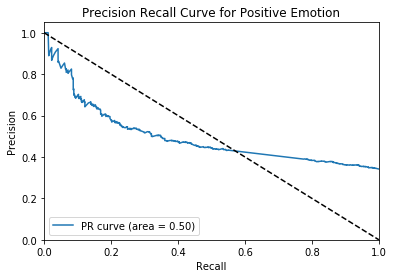

MINIMUM DOCUMENT FREQUENCY = 19

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.31      0.09      0.14       436
No emotion toward brand or product       0.67      0.81      0.73      4124
                  Positive emotion       0.53      0.39      0.45      2295

                          accuracy                           0.63      6855
                         macro avg       0.50      0.43      0.44      6855
                      weighted avg       0.60      0.63      0.60      6855



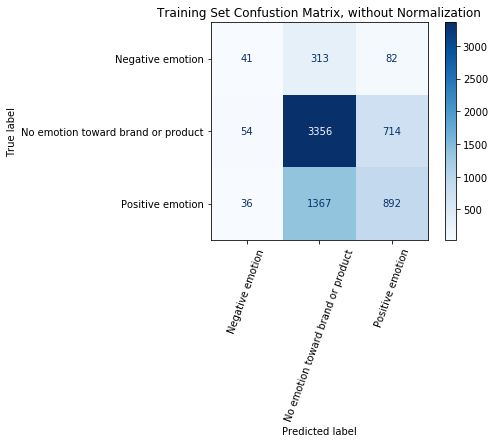

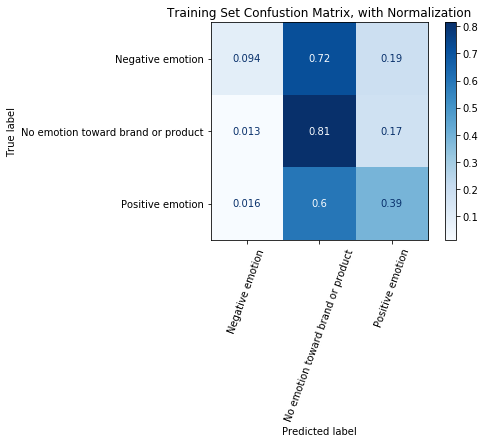

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.18      0.04      0.06       109
No emotion toward brand or product       0.65      0.78      0.71      1031
                  Positive emotion       0.49      0.40      0.44       574

                          accuracy                           0.60      1714
                         macro avg       0.44      0.40      0.40      1714
                      weighted avg       0.57      0.60      0.58      1714



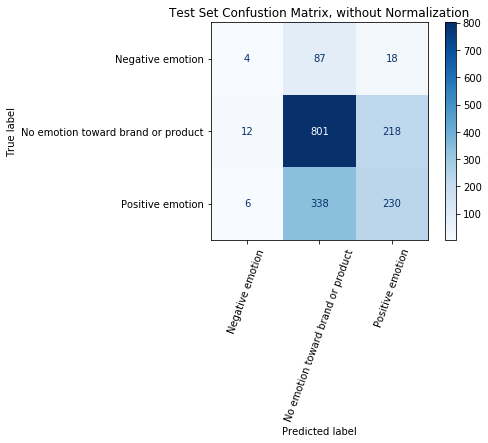

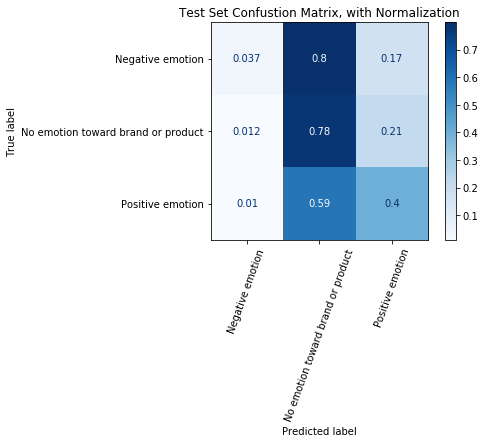

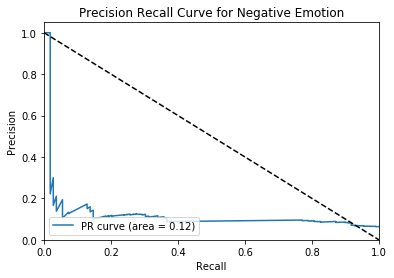

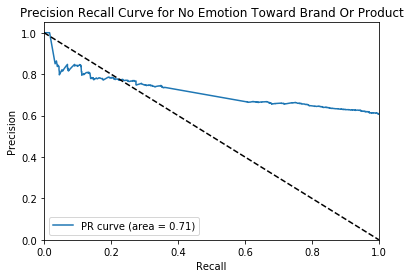

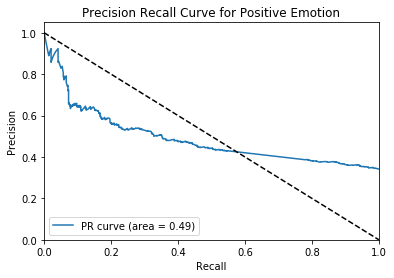

MINIMUM DOCUMENT FREQUENCY = 20

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.32      0.09      0.14       436
No emotion toward brand or product       0.66      0.82      0.73      4124
                  Positive emotion       0.53      0.38      0.44      2295

                          accuracy                           0.63      6855
                         macro avg       0.51      0.43      0.44      6855
                      weighted avg       0.60      0.63      0.60      6855



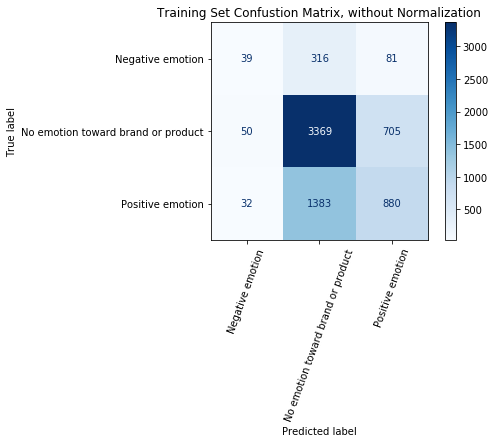

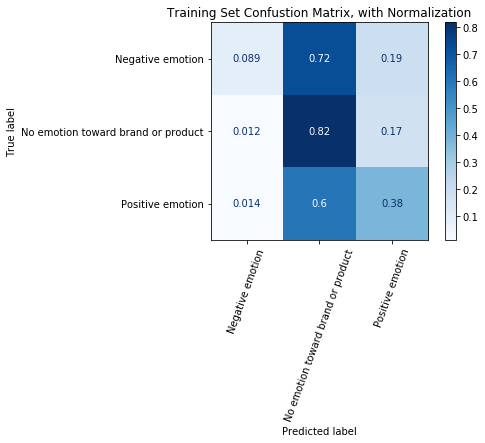

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.17      0.04      0.06       109
No emotion toward brand or product       0.65      0.78      0.71      1031
                  Positive emotion       0.50      0.40      0.44       574

                          accuracy                           0.61      1714
                         macro avg       0.44      0.41      0.40      1714
                      weighted avg       0.57      0.61      0.58      1714



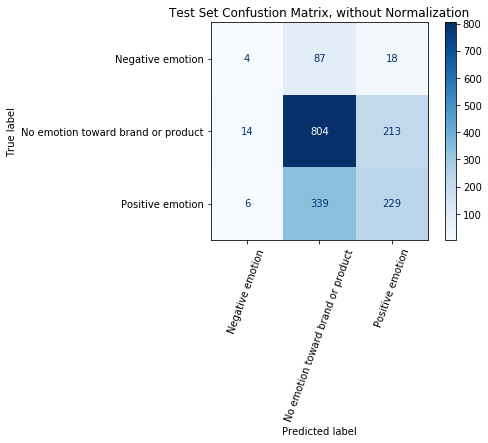

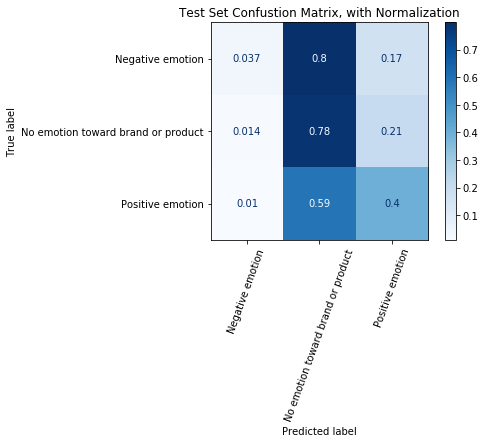

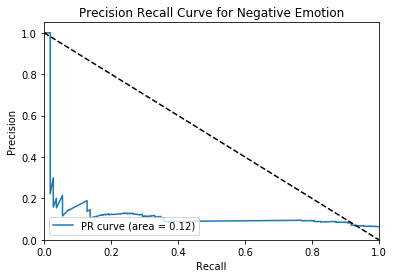

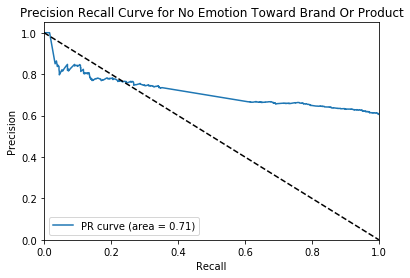

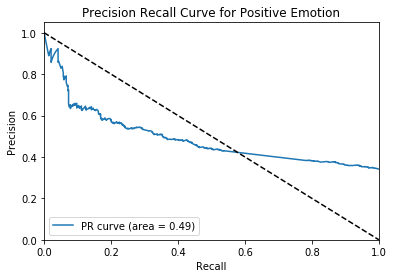

In [18]:
metrics_summary = []

for min_df in range(1,21):
    test_scores = train_and_eval_model(min_df, ngram_range=(2,2))
    metrics_summary.append(test_scores)

In [19]:
metrics_summary_df = pd.DataFrame(metrics_summary, 
                                  columns=['min doc freq',
                                           'train accuracy',
                                           'test accuracy',
                                          'neg f1',
                                          'neutral f1',
                                          'pos f1'])

metrics_summary_df

min doc freq  train accuracy  test accuracy    neg f1  neutral f1  \
0            1.0        0.823778       0.656359  0.236842    0.737674   
1            2.0        0.821298       0.653442  0.267516    0.735814   
2            3.0        0.776368       0.640023  0.274286    0.726585   
3            4.0        0.737126       0.620770  0.232044    0.710014   
4            5.0        0.717724       0.614352  0.222222    0.706435   
5            6.0        0.701678       0.605018  0.190476    0.702878   
6            7.0        0.688403       0.604434  0.192771    0.704639   
7            8.0        0.673523       0.600350  0.172840    0.698427   
8            9.0        0.668271       0.604434  0.185185    0.701335   
9           10.0        0.661561       0.607351  0.230769    0.702332   
10          11.0        0.653829       0.602684  0.186667    0.700318   
11          12.0        0.651058       0.604434  0.157143    0.705405   
12          13.0        0.642159       0.608518  0.158273    0.711230   
13          14.0        0.640554       0.614936  0.159420    0.717266   
14          15.0        0.636324       0.613769  0.159420    0.716881   
15          16.0        0.632093       0.610268  0.132353    0.714349   
16          17.0        0.628592       0.603851  0.104478    0.710106   
17          18.0        0.629322       0.604434  0.090226    0.710678   
18          19.0        0.625675       0.603851  0.061069    0.709792   
19          20.0        0.625529       0.605018  0.060150    0.711190   

      pos f1  
0   0.557726  
1   0.549509  
2   0.535558  
3   0.517544  
4   0.500000  
5   0.477396  
6   0.466359  
7   0.471014  
8   0.473925  
9   0.470046  
10  0.461538  
11  0.453184  
12  0.447847  
13  0.453230  
14  0.449177  
15  0.447646  
16  0.437380  
17  0.439306  
18  0.442308  
19  0.442940

MINIMUM DOCUMENT FREQUENCY = 3

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.62      0.54      0.58       436
No emotion toward brand or product       0.82      0.83      0.83      4124
                  Positive emotion       0.72      0.72      0.72      2295

                          accuracy                           0.78      6855
                         macro avg       0.72      0.70      0.71      6855
                      weighted avg       0.78      0.78      0.78      6855



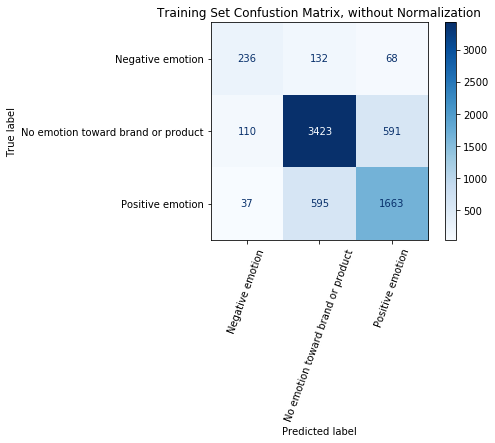

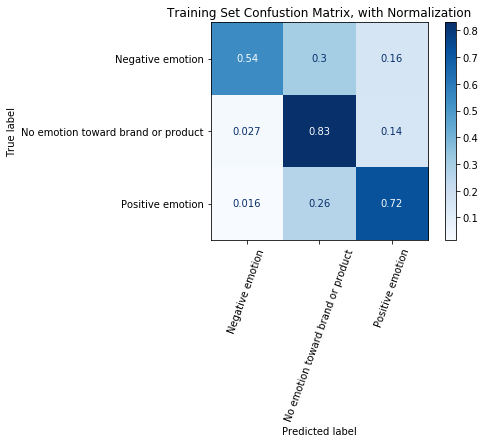

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.36      0.22      0.27       109
No emotion toward brand or product       0.71      0.74      0.73      1031
                  Positive emotion       0.54      0.53      0.54       574

                          accuracy                           0.64      1714
                         macro avg       0.54      0.50      0.51      1714
                      weighted avg       0.63      0.64      0.63      1714



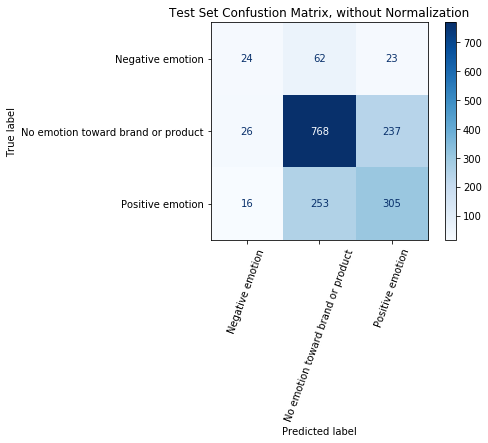

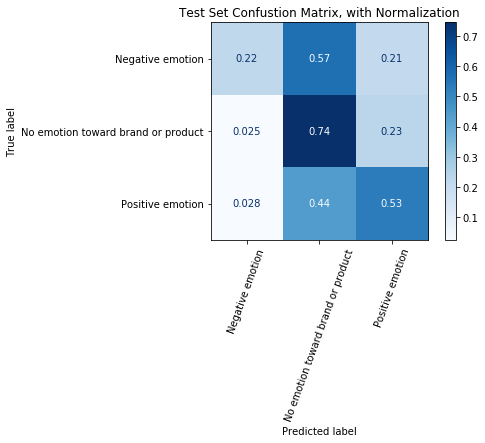

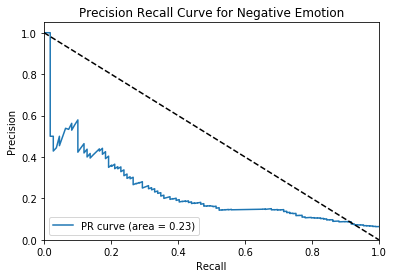

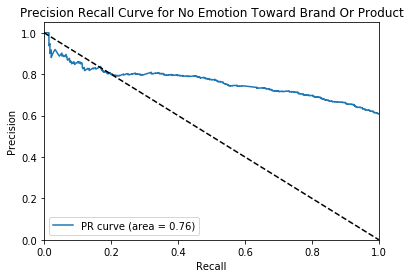

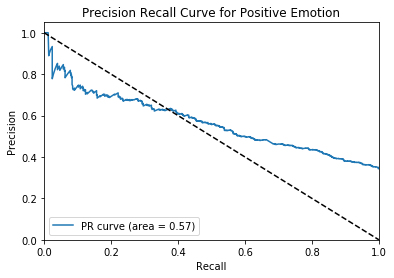

In [21]:
metrics = train_and_eval_model(min_df=3, ngram_range=(2,2))

# Summary

In the model with bi-grams, the performance is worse than the baseline and the Naive Bayes Classifier model that adjusted for minimum document frequency.  

At least with this dataset creating bi-grams has a negative effect on performance when using a Naive Bayes Classifier.